<a href="https://colab.research.google.com/github/lvllvl/unet/blob/master/Alt_SegmentationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Overview

## Notes

* imgs/  -- The png image files
* masks/ -- PNG segmentation masks (update these!)
* segs/  -- The outputs in probability from our * * 
internal segnet (unreleased, too big)



###### Categories 
 * 1 - #402020 - road (all parts, anywhere nobody would look at you funny for driving)
 * 2 - #ff0000 - lane markings (don't include non lane markings like turn arrows and crosswalks)
 * 3 - #808060 - undrivable
 * 4 - #00ff66 - movable (vehicles and people/animals)
 * 5 - #cc00ff - my car (and anything inside it, including wires, mounts, etc. No reflections)



In [1]:
import keras
import tensorflow as tf

print( tf.__version__ )
print( keras.__version__ ) 

2.3.0
2.4.3


## Imports

In [2]:
from pathlib import Path
import pathlib
from PIL import  Image
import cv2
import numpy as np
from keras.utils import to_categorical
from scipy import misc
import matplotlib.pyplot as plt
from numpy import  linalg
import tensorflow as tf 

#### import comma10k Dataset 

In [3]:
! git clone https://github.com/commaai/comma10k.git

Cloning into 'comma10k'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 30985 (delta 3), reused 6 (delta 0), pack-reused 30970
Receiving objects: 100% (30985/30985), 3.76 GiB | 45.13 MiB/s, done.
Resolving deltas: 100% (4722/4722), done.
Checking out files: 100% (11196/11196), done.


#### Set up the folders, paths 

In [4]:
path = Path.cwd()

# Comma10k data
comma10kFolder = path/'comma10k'
masksFolder = comma10kFolder/'masks' # Images with the masks ( 5574 images )
imgsFolder = comma10kFolder/'imgs' # Images with no segmentation

# Unet Path 
# you don't need this 
# unetFolder = path/'unet'


# Create directories for Train / validation datasets 
validFiles = comma10kFolder/'valid'
validFiles.mkdir( mode=511, parents= True, exist_ok = False )

trainFiles = comma10kFolder/'train'
trainFiles.mkdir( mode=511, parents=True, exist_ok=False )

# Training folder --> mask folder --> masks.png
# Training folder --> image folder --> image.png
# Valid folder --> mask folder --> masks.png
# Valid folder --> image folder --> image.png

#### ***** Uncomment for sub directories mask, image for training set, valid set 
trainMask = trainFiles/'mask'
trainMask.mkdir( mode=511, parents=True, exist_ok = False )
trainImage = trainFiles/'image'
trainImage.mkdir( mode=511, parents=True, exist_ok = False )
validMask = validFiles/'mask'
validMask.mkdir( mode=511, parents=True, exist_ok = False )
validImage = validFiles/'image'
validImage.mkdir( mode=511, parents=True, exist_ok = False )

/content/comma10k/imgs/4205_cc0342d8a2184b9d_2018-06-27--07-08-09_66_268.png


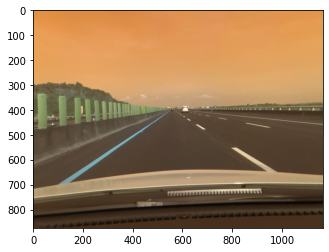

In [5]:
img = 0
for i in imgsFolder.iterdir():
  name = i.as_uri()[ 7: ]
  print( name )
  img = cv2.imread( name )
  break 
img.shape
# (874, 1164, 3)
# (874, 1164, 3)
plt.imshow( img )

/content/comma10k/masks/4205_cc0342d8a2184b9d_2018-06-27--07-08-09_66_268.png
mask.shape:  (874, 1164, 3)


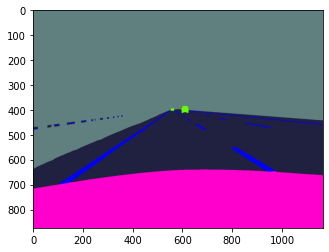

In [6]:
mask = 0 
for i in masksFolder.iterdir():
  name = i.as_uri()[ 7: ] 
  print( name ) 
  mask = cv2.imread( name ) 
  break 

print( 'mask.shape: ' , mask.shape ) 
plt.imshow( mask ) 

## Data Preparation

#### Rename files, Split into Train/Valid sets

In [ ]:
# trainImage = trainFiles/'image'
# validImage = validFiles/'image'

# trainMask = trainFiles/'mask'
# validMask = validFiles/'mask'

# Process Masks #############################################
files_processed = 0
label = '_m'
suffix = '.png'

all_train_nums = []
all_valid_nums = [] 
train_dic = {}
valid_dic = {} 

for i in masksFolder.iterdir():
  # 1. Get file num, create new name 
  file_path = str( i ) 
  file_num = file_path[ 24 : 28 ] # Create file_path/#### --> unique file number 
  new_fn = file_num + label + suffix # create new file name 

  # 2. Split mask files into Training set or Valid set 
  if files_processed < 4459:
    i.rename( Path( trainMask, new_fn )) # Change the file name
    posix_file_path = trainMask/new_fn # Document new file path 
    train_dic[ file_num ] = [ str( posix_file_path )]
    all_train_nums.append( file_num ) # track all file nums processed
  else:
    i.rename( Path( validMask, new_fn )) 
    posix_file_path = validMask/new_fn
    valid_dic[ file_num ]  = [ str( posix_file_path ) ]
    all_valid_nums.append( file_num )
    
  # 3. Track number of total files processed
  files_processed += 1

  if files_processed % 500 == 0:
    print( 'Still processing MASKS...file count = ', files_processed )

Still processing MASKS...file count =  500
Still processing MASKS...file count =  1000
Still processing MASKS...file count =  1500
Still processing MASKS...file count =  2000
Still processing MASKS...file count =  2500
Still processing MASKS...file count =  3000
Still processing MASKS...file count =  3500
Still processing MASKS...file count =  4000
Still processing MASKS...file count =  4500
Still processing MASKS...file count =  5000
Still processing MASKS...file count =  5500


In [ ]:
# trainImage = trainFiles/'image'
# validImage = validFiles/'image'

# # Process IMages #############################################
files_processed = 0 
label = '_i'
suffix = '.png'

for i in imgsFolder.iterdir():

  # 1. Get file num, create new name 
  file_path = str( i ) 
  file_num = file_path[ 23 : 27 ] # Create file_path/#### --> unique file number 
  new_fn = file_num + label + suffix # create new file name 

  # 2. Split mask files into Training set or Valid set 
  if file_num in train_dic: 
    i.rename( Path( trainImage, new_fn )) # change the file name
    
    posix_file_path = trainImage/new_fn # Document new file path 
    train_dic[ file_num ].append( str( posix_file_path ) ) # append image file name 
    
  else:
    i.rename( Path( validImage, new_fn )) 
    posix_file_path = validImage/new_fn
    valid_dic[ file_num ].append( str( posix_file_path ) )
    all_valid_nums.append( file_num )

  # 3. Track number of total files processed
  files_processed += 1
  
  if files_processed % 500 == 0:
    print( 'Still processing IMAGES...file count = ', files_processed )

Still processing IMAGES...file count =  500
Still processing IMAGES...file count =  1000
Still processing IMAGES...file count =  1500
Still processing IMAGES...file count =  2000
Still processing IMAGES...file count =  2500
Still processing IMAGES...file count =  3000
Still processing IMAGES...file count =  3500
Still processing IMAGES...file count =  4000
Still processing IMAGES...file count =  4500
Still processing IMAGES...file count =  5000
Still processing IMAGES...file count =  5500


In [ ]:
path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
path = tf.keras.Model.

In [ ]:
mask = 0 
img = 0 

for i in masksFolder.iterdir():
  mask += 1
for i in imgsFolder.iterdir():
  img += 1

print( mask, img )

0 0


In [ ]:
print('Training_dic size:', len( train_dic ))
print('Valid_dic size:', len( valid_dic ))

Training_dic size: 4459
Valid_dic size: 1115


#### Split files into train / valid folders

In [ ]:
# # Masked Files -- Change location 
# fileNames = []
# count = 0

# for i in masksFolder.iterdir():

#   fn = i.stem + i.suffix # file name
#   # print( 'fn = ', fn ) 

#   if count < 4459:  # add to Train folder 
#     fileNum = i.stem[ 5: ]
#     fileNames.append( fileNum ) # append FileNum to fileNames array 
    
#     # Now change the location 
#     i.rename( Path( trainFiles, fn ))

#   else: # add to Valid folder
#     i.rename( Path( validFiles, fn ))


#   count += 1

# print( 'len of fileNames: ', len( fileNames ))
# c= 0
# for i in trainFiles.iterdir():
#   c += 1
# print( c )

len of fileNames:  4459
2


In [ ]:
# # Now move the images from the imgsFolder 
# for i in imgsFolder.iterdir():

#   fn = i.stem + i.suffix # individual file name 
  
#   fileNum = i.stem[ 6: ]

#   if fileNum in fileNames: # change location - train folder if fileNum is in array fileNames
#     i.rename( Path( trainFiles, fn ))

#   else: # change location  - valid folder 
#     i.rename( Path( validFiles, fn ))

# c = 0
# for i in trainFiles.iterdir():
#   c += 1 
# print( c ) 

2


## New Section 

In [ ]:
! pip install -q git+https://github.com/tensorflow/examples.git
! pip install -q -U tfds-nightly

     |████████████████████████████████| 3.5MB 2.9MB/s 


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow as tf 

import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePZ399I/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePZ399I/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize( input_image, input_mask ):
  input_image = tf.cast( input_image, tf.float32 ) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function # TODO : What is this? 

def load_image_train( input_image, input_mask ):
  
  # Open images 
  img = cv2.imread( input_image )
  mask = cv2.imread( input_mask ) 
  mask = mask[ :, :, 0 ] # one channel from mask 

  # Resize images 
  input_image = tf.image.resize( img, (128, 128 ))
  input_mask = tf.image.resize( mask, (128,128))
  
  # Flip images if necessary 
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  # Normalize images 
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask # output Tuple 

def load_image_test( input_image, input_mask ):
  # Open images 
  img = cv2.imread( input_image )
  mask = cv2.imread( input_mask )
  mask = mask[ :, :, 0 ] # one channel from mask 

  # Resize images 
  input_image = tf.image.resize( img, (128, 128 ))
  input_mask = tf.image.resize( mask, (128,128))
  
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
# map( funciton, d ) 
# img = cv2.imread( d[13434][0])
# input_image = tf.image.resize( )

'image file name '

In [ ]:
e = tf.data.Dataset.prefetch( )
# tf.python.data.ops.dataset_ops.PrefetchDataset( train_dic, buffer_size=BUFFER_SIZE  )

TypeError: ignored

In [ ]:
TRAIN_LENGTH = len( train_dic ) 
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE 

# TRAIN_LENGTH = info.splits['train'].num_examples
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
# tf.data.Dataset.map( load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE )
tf.data.Dataset( )

In [ ]:
# zz = tf.python.data.ops.dataset_ops.ParallelMapDataset( dataset, 
#                                                        map_func= map,
#                                                        num_parallel_calls = tf.data.experimental.AUTOTUNE )

tf.python.data.ops.dataset_ops.ParallelMapDataset??

In [ ]:
z = train_dic['0001'].map( load_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE )

AttributeError: ignored

In [ ]:
train = [] 
for key in train_dic:

  # train = map( load_image_train, train_dic[key][1], train_dic[key][0])
  train.append( train_dic[key][1] )
  train.append( train_dic[key][0] )



# train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle( BUFFER_SIZE ).batch( BATCH_SIZE ).repeat()
train_dataset = train_dataset.prefetch( buffer_size=tf.data.experimental.AUTOTUNE )
valid_dataset = valid.batch( BATCH_SIZE ) 

# train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_dataset = test.batch(BATCH_SIZE)

AttributeError: ignored

In [ ]:
# display images 
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

AttributeError: ignored

In [ ]:
OUTPUT_CHANNELS = 3 # 5

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
# Define the model 
def unet_model(output_channels):

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack( x )
  x = skips[ -1 ]
  skips = reversed( skips[ :-1 ] )

  # Upsampling and establishing the skip connections
  for up, skip in zip( up_stack, skips ):
    x = up( x )
    concat = tf.keras.layers.Concatenate()
    x = concat([ x, skip ])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model( OUTPUT_CHANNELS )
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

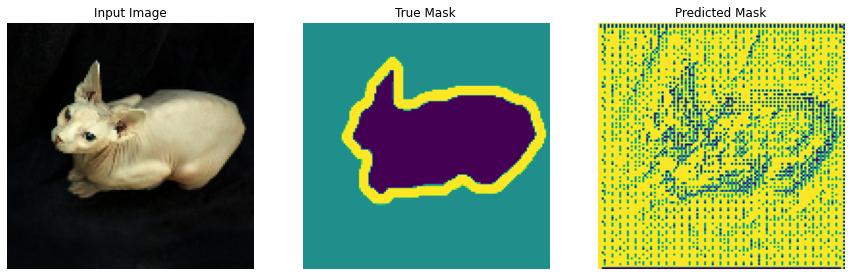

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback( tf.keras.callbacks.Callback ):

  def on_epoch_end( self, epoch, logs = None ):
    clear_output( wait = True )
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format( epoch + 1 ) )

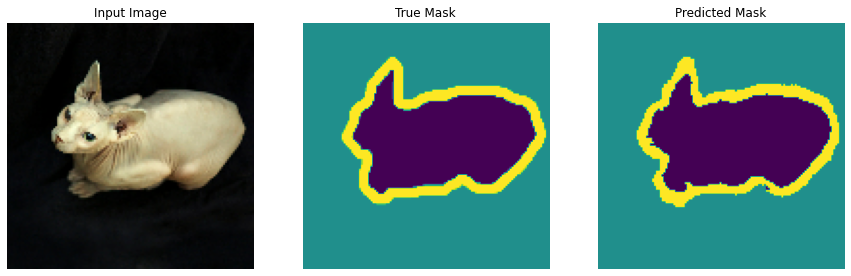


Sample Prediction after epoch 20

57/57 [==============================] - 6s 108ms/step - loss: 0.1344 - accuracy: 0.9388 - val_loss: 0.3122 - val_accuracy: 0.8909


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5 # ???
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
print( VALIDATION_STEPS ) 

model_history = model.fit( train_dataset, epochs = EPOCHS,
                           steps_per_epoch = STEPS_PER_EPOCH,
                           validation_steps = VALIDATION_STEPS,
                           validation_data = test_dataset,
                           callbacks = [ DisplayCallback() ] )

In [ ]:
print(info.splits['train'].num_examples // BATCH_SIZE // VAL_SUBSPLITS )

print( BATCH_SIZE )

print( VAL_SUBSPLITS)

11
64
5


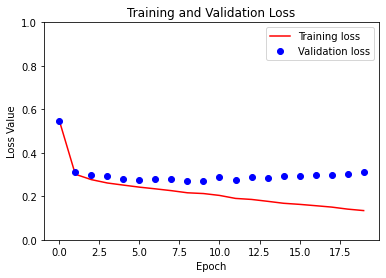

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

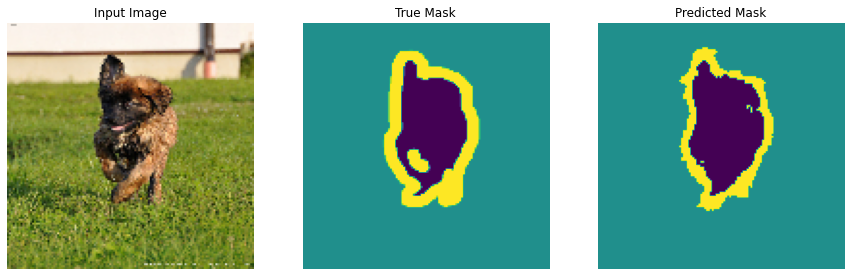

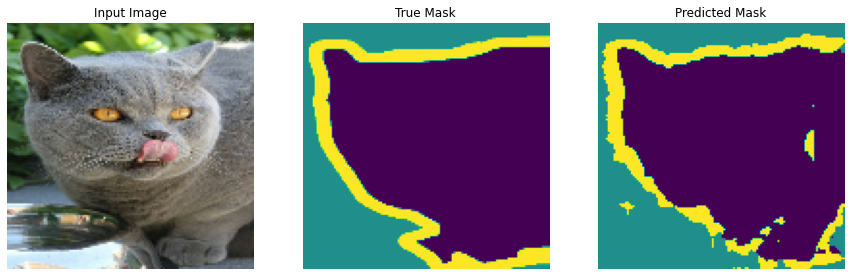

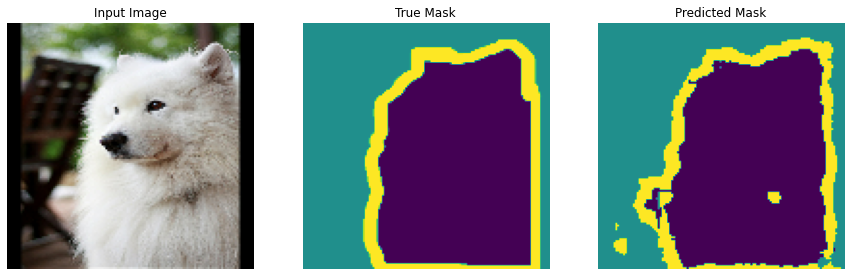

In [ ]:
show_predictions(test_dataset, 3)

## Data.py

##### Imports, etc

In [ ]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

# CommaAI Labels --> 5 classes
road = [ 64,	32,	32 ] 
lane_markings = [ 255, 0, 0 ] 
undriveable = [ 128, 128, 96 ] 
movable = [ 0, 255, 102 ] # vehicles, peoples, animals 
my_vehicle = [ 204,	0, 255 ]

# What does this do?
COLOR_DICT = np.array( [ road, lane_markings, undriveable, movable, my_vehicle ])

In [ ]:
# # # Goal - replace adjustData --> create a one-hot-vector --> 
def adjustData( img, mask, flag_multi_class, num_classes ):

  if ( flag_multi_class ): # If classes > 2
    
    img = tf.cast( img, tf.float32 ) / 255.0 # TODO --> is this the right choice here?
    input_image = 0
    input_image = tf.cast( input_image, tf.float32 ) / 255.0 

    mask = mask[ :, :, 0 ] # Select 1 channel from mask
    mask = tf.cast( mask, tf.float32 ) / 255.0
    mask_one_hot = to_categorical( mask, num_classes = num_classes )
    
  return ( img, mask_one_hot ) 

####################################################################################################
####################################################################################################

def train_Generator( batch_size, train_path, image_color_mode = "rgb",
                    mask_color_mode = "rgb", image_save_prefix  = "image", mask_save_prefix  = "mask",
                    flag_multi_class = True, num_class = 5, save_to_dir = None, target_size = ( 256,256 ), seed = 1 ):
#     '''
#     can generate image and mask at the same time
#     use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
#     if you want to visualize the results of generator, set save_to_dir = "your path"
#     '''
#     # Create Image Data Generators 
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_directory(
        train_path,
        target_size = target_size,
        color_mode = image_color_mode,
        class_mode = None,
        batch_size = batch_size,
        seed = seed,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix
        )
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        target_size = target_size,
        color_mode = mask_color_mode,
        class_mode = None,
        batch_size = batch_size,
        seed = seed,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix
        )
    
#     # zip them together 
    train_generator = zip( mask_generator, image_generator )

    for (img,mask) in train_generator:
      img,mask = adjustData( img, mask, flag_multi_class, num_class )
      yield ( img, mask )

####################################################################################################
####################################################################################################
####################################################################################################
def labelVisualize( num_class, color_dict, img ):

    img = img[ :,:,0 ] if len( img.shape ) == 3 else img

    img_out = np.zeros( img.shape + (3,) )

    for i in range( num_class ):
        img_out[ img == i,: ] = color_dict[ i ]

    return img_out / 255

####################################################################################################
####################################################################################################
####################################################################################################

def saveResult( save_path, npyfile, flag_multi_class = False, num_class = 2 ):
  '''
  save_path -->
  npyfile --> 
  flag_multi_class --> bool 
  num_class --> 

  '''

  for i,item in enumerate( npyfile ):

      img = labelVisualize( num_class, COLOR_DICT, item ) if flag_multi_class else item[ :,:,0 ]

      io.imsave( os.path.join( save_path,"%d_predict.png"%i ),img )

####################################################################################################
####################################################################################################
####################################################################################################

## Create the Model

### Model.py

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import tensorflow as tf 

# (874, 1164, 3)
def unet( pretrained_weights = None, input_size = [ 256, 256, 3 ] ):
    
    # downsampling begins here 
    inputs = Input( input_size )
    conv1 = Conv2D( 64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' )( inputs )
    conv1 = Conv2D( 64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' )( conv1 )
    pool1 = MaxPooling2D( pool_size=( 2, 2 ))( conv1 )

    conv2 = Conv2D( 128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' )( pool1 )
    conv2 = Conv2D( 128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( conv2 )
    pool2 = MaxPooling2D( pool_size=( 2, 2 ))( conv2 )

    conv3 = Conv2D( 256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( pool2 )
    conv3 = Conv2D( 256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( conv3 )
    pool3 = MaxPooling2D( pool_size=(2, 2))(conv3)

    conv4 = Conv2D( 512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( pool3 )
    conv4 = Conv2D( 512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')( conv4 )
    drop4 = Dropout( 0.5 )( conv4 )
    pool4 = MaxPooling2D( pool_size=( 2, 2 ))( drop4 )

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    ## upsampling begins here 
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9) 
    

    model = Model( inputs, conv10 )
    # model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    # model.compile( optimizer = Adam( lr = 1e-4), loss = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True ),
    #               metrics = [ 'accuracy' ] )

    if (pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

## Execute the model 

### Main.py

In [ ]:
model = unet()

In [ ]:
train_dir = '/content/comma10k/train' # set directory variables
valid_dir = '/content/comma10k/valid' 


# train_m = train_dir + '/mask'
# train_im = train_dir + '/image'

model = unet() # Declare model variable 

# Create a model check point 
model_checkpoint = ModelCheckpoint( train_dir,
                                   monitor = 'loss',
                                   verbose = 2, 
                                   save_best_only=False )


# call train_generator function 
train_dataset = train_Generator( batch_size = 32, train_path = train_dir, image_color_mode='rgb',
                                  mask_color_mode='rgb', flag_multi_class=True, num_class=5, 
                                  target_size = (256, 256) )


model.fit( train_dataset, batch_size=32, epochs=5, verbose=2,
          shuffle= True, steps_per_epoch=1 )

# results = model.predict_generator( testGene,
#                                    30,
#                                    verbose=1 )

AttributeError: ignored

## Save Model, Save Predictor

In [ ]:
model.summary() 

# Save your results HERE
# saveResult( validDir,
#             results )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (